In [9]:
import sys
sys.path.append('../src') # hack to add the source code directory!
from ContinuumExcitableElasticity import pde, ContourPlotAnimator
from pde import CartesianGrid, Controller, MemoryStorage, ScalarField, FieldCollection, PlotTracker, ExplicitSolver,VectorField
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
# Simulation parameters
# Physical Box Size
L=20
# number of points, its easier to do the math if this is odd
Npts=101
#derived grid spacing
h= L/(Npts-1)
# Run time
T=10
#timestep
dt=1e-3
# Time interval for printing
pt = 0.5
# Material Parameters
B=1.
mu=1.
eta=1.
ko=1.
mu_tilde=2.
gamma=0.
rho=1.

### Some numbers its good to know ###
J=ko**2
ViscThresh=J-(B/2)**2
qc=np.sqrt(( rho/(eta**2) )*( (J-((B/2)**2))/(mu+(B/2)) ))
lamc=(2*np.pi)/qc

# initialise the PDE
bc='auto_periodic_dirichlet' #periodic or dirichlet depending on periodic=...
eq = pde(B,mu,eta,ko,mu_tilde,gamma,rho,L, bc)

# Initialise the Grid
bounds=[(-L/2,L/2),(-L/2,L/2)]
shape=[Npts,Npts]
grid = CartesianGrid(bounds,shape, periodic=[True,True])

# now feed in an initial state
# Random Fuzz

# random fuzz for an ic
A=0.1
ux_init=np.random.rand(Npts,Npts)-0.5
uy_init=np.random.rand(Npts,Npts)-0.5
u_init= A*np.array([ux_init,uy_init])

px_init=np.random.rand(Npts,Npts)-0.5
py_init=np.random.rand(Npts,Npts)-0.5
p_init= A*np.array([px_init,py_init])

state = FieldCollection([VectorField(grid,u_init),VectorField(grid,p_init)])

In [5]:
# GOGO!
storage = MemoryStorage()
trackers = ['progress', 'consistency', storage.tracker(interval=pt) ]
solver1 = ExplicitSolver(eq)
controller1 = Controller(solver1, t_range=T, tracker=trackers)
sol1 = controller1.run(state,dt=dt)
print("Diagnostic information:")
print(controller1.diagnostics)

100%|█████████████████████████████████████████████████████████████████████████████████████| 10.0/10.0 [00:37<00:00,  3.73s/it]

Diagnostic information:
{'controller': {'t_start': 0, 't_end': 10.0, 'solver_class': 'ExplicitSolver', 'solver_start': '2021-10-10 16:45:04.596159', 'profiler': {'solver': 37.225649, 'tracker': 0.025975999999997557}, 'successful': True, 'stop_reason': 'Reached final time', 'solver_duration': '0:00:37.298326', 't_final': 10.001}, 'package_version': '0.16.4', 'solver': {'class': 'ExplicitSolver', 'pde_class': 'pde', 'dt': 0.001, 'steps': 10001, 'scheme': 'euler', 'state_modifications': 0.0, 'backend': 'numpy', 'stochastic': False}, 'jit_count': {'make_stepper': 1, 'simulation': 8}}


In [6]:
# extract the data

# make empty arrays
Length=sum(1 for _ in storage.items())
times=np.empty([Length])
uxdata=np.empty([Length, Npts,Npts]) # scalar field (time, y, x), as np is row/column!
uydata=np.empty([Length, Npts,Npts]) # scalar field (time, y, x), as np is row/column!
divudata=np.empty([Length, Npts,Npts]) # scalar field (time, y, x), as np is row/column!
shearphasedata=np.empty([Length, Npts,Npts]) # scalar field (time, y, x), as np is row/column!
shearmagdata=np.empty([Length, Npts,Npts]) # scalar field (time, y, x), as np is row/column!

# read data in to those arrays in a loop
mygenerator=storage.items()
for count in range(0,Length):
    time,field=next(mygenerator)

    ux=field[0].data[0,:,:]
    uy=field[0].data[1,:,:]
    # Calculate the Shear and Bulk Deformations
    u=VectorField(grid,np.array([ux,uy]))
    # bulk
    divu=u.divergence(bc).data
    #shear
    diuj= u.gradient(bc)       
    Sij=diuj.symmetrize(make_traceless=True) # the traceless part of the strain tensor
    # the complex representation
    z=Sij.data[0,0,:,:]+Sij.data[0,1,:,:]*1j
    
    # read in the data into a big numpy array
    times[count]=time
    uxdata[count,:,:]=ux
    uydata[count,:,:]=uy
    shearphasedata[count,:,:]=np.angle(z)
    shearmagdata[count,:,:]=np.abs(z)
    divudata[count,:,:]=divu
    

<IPython.core.display.Javascript object>


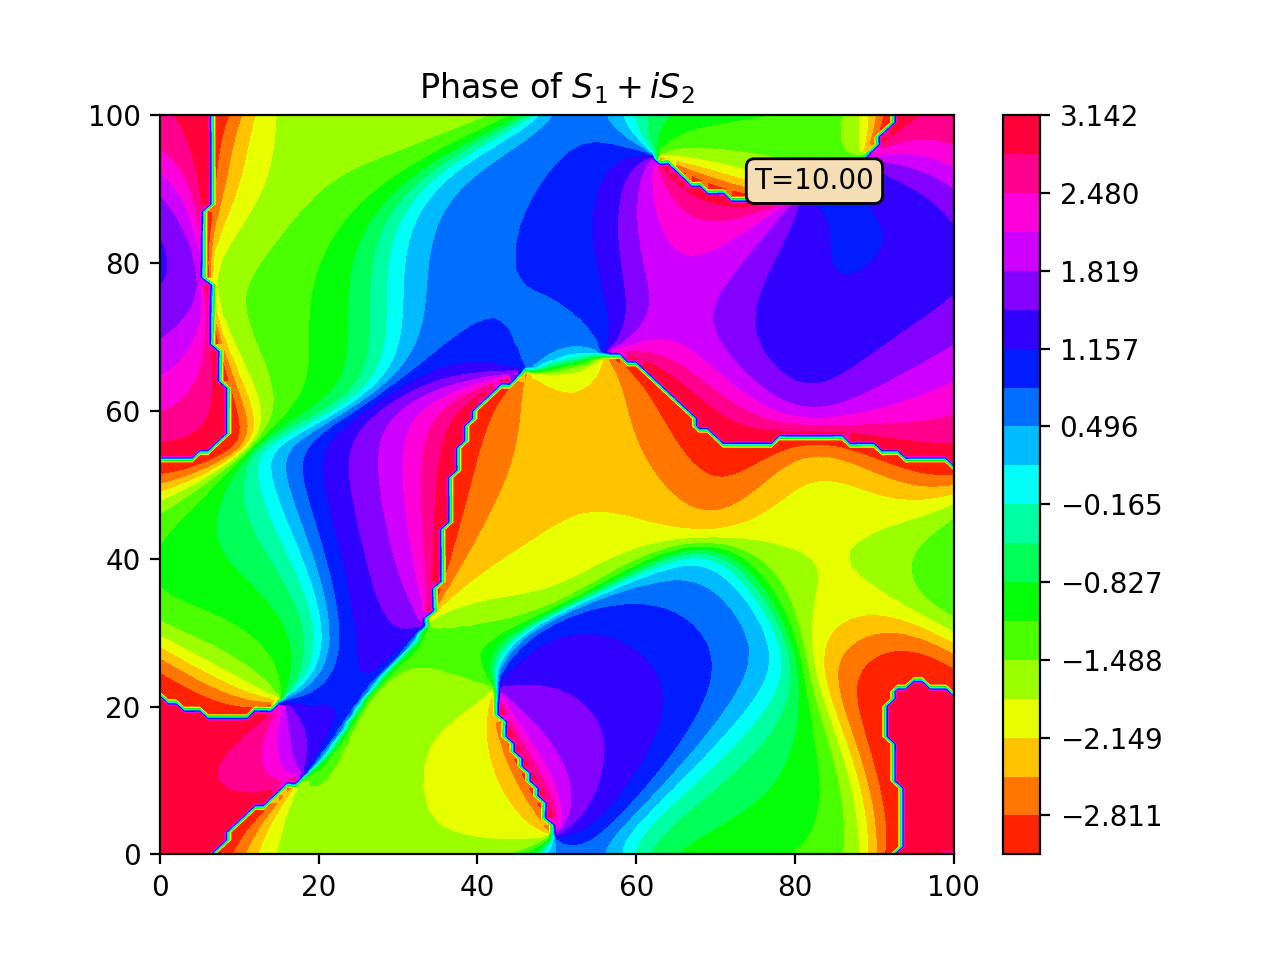

In [10]:
# visualise the data
x=ContourPlotAnimator(shearphasedata,times,'Phase of $S_1+i S_2$',cmap=plt.get_cmap("hsv"))
#x.save('Phase_S1+iS2.mp4',fps=20)

In [ ]:
x=ContourPlotAnimator(shearmagdata,times,'Magnitude of $S_1+i S_2$',cmap=plt.get_cmap("viridis"))
#x.save('Magnitude_S1+iS2.mp4',fps=20)

In [ ]:
x=ContourPlotAnimator(divudata,times,'Magnitude of div(u)',cmap=plt.get_cmap("viridis"))
#x.save('Magnitude_divu.mp4',fps=20)